# Sensitivity analysis 

In [1]:
%pylab inline
import downglacier.sandbox.tcd_utils as utils
import downglacier.graphics as dgplot
import seaborn as sns
import pandas as pd
from datetime import datetime as dt
pal = sns.color_palette('pastel')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.2)
from collections import OrderedDict
import scipy.signal
import scipy.stats as stats
from scipy.stats.stats import pearsonr
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
lag=3

In [3]:
keyss = dict()
keys = OrderedDict()
keys['step_pcor01']  = ['$S_{Pcor}$', 'Stepwise, partial correlation']
keys['step_rmse01']  = ['$S_{RMSE}$', 'Stepwise, RMSE']
keys['step_pc_pcor01']  = ['$S_{PC}$', 'Stepwise, principle components']
keys['lasso_8fold']  = ['$L_{8fold}$', 'Lasso: 8-fold crossval']
keys['ref']  = ['$Ref$', 'Reference run']
keyss['method'] = keys
keys = OrderedDict()
keys['preds_lag1']  = ['$Lag_{1}$', '+ Lag 1 predictors']
keys['preds_hpa']  = ['$hPa$', 'Levels: 300, 400, 500, 600, 700']
keys['preds_notemp']  = ['$No_{Temp}$', 'No temperature']
keys['preds_noscf']  = ['$No_{Sfc}$', 'No surface variables']
keys['preds_norh']  = ['$No_{RH}$', 'No relative humidity']
keys['preds_ref']  = ['$Ref$', 'Reference run']
keyss['preds'] = keys
keys = OrderedDict()
keys['rea_era']  = ['$ERA$', 'Levels: 300, 400, 500, 600, 700']
keys['rea_cfsr']  = ['$CFSR$', 'Levels: 300, 400, 500, 600, 700']
keys['rea_merra']  = ['$MERRA$', 'Levels: 300, 400, 500, 600, 700']
keys['rea_ncep']  = ['$NCEP$', 'Levels: 300, 400, 500, 600, 700']
keyss['reas'] = keys
titles = ['Algorithm', 'Predictors', 'Reanalyses']

In [4]:
wd = utils.run_sensis(run=False)
print(wd)

/home/mowglie/DownGlacier_tcd_runs/run_sensis


In [5]:
def get_dirs(a_dir):
    return [name for name in os.listdir(a_dir) if os.path.isdir(os.path.join(a_dir, name))]

In [6]:
sss = ['method', 'preds', 'reas']
dfs = []
dfd = []
dfsst = utils.get_enso_df(lag=lag).loc[dt(1979,10,1):dt(2013,9,1)]
ydfsst = dfsst.groupby('yi').mean()['sst']
for ss in sss:
    lexp = get_dirs(os.path.join(wd, ss))
    _dfs = pd.DataFrame()
    _dfd = pd.DataFrame()
    for l in lexp:
        resfile = os.path.join(wd, ss, l, 'diagnostics', 'results.csv')
        predfile = os.path.join(wd, ss, l, 'diagnostics', 'predict_ts.csv')
        dfi = pd.read_csv(resfile, index_col=0).T
        _dfs[l] = dfi['mbtotfromsum_4750_diag']
        dfi = pd.read_csv(predfile, index_col=0, parse_dates= {"time" : [0]})
        _dfd[l] = dfi['mbtotfromsum_4750_diag'] / 1000.
    
    _dfd = _dfd.loc[dt(1979,10,1):dt(2013,9,1)]
    _dfd['yi'] = dfsst['yi']
    _dfd = _dfd.groupby('yi').aggregate(lambda x: x.sum() if x.count() == 12 else np.NAN)
    
    fdf = _dfd.copy()
    fdf['sst'] = ydfsst.values
    fdf = fdf.dropna()
    fdfd = fdf.apply(scipy.signal.detrend)
    keys = keyss[ss]
    _dfs = _dfs[list(keys.keys())].loc[['outercv_rmse','outercv_percsigma','outercv_skillscore']]
    
    for k, v in keys.items():
        _dfs.loc['Comment', k] = v[1]
        
        r, p_value = pearsonr(fdf[k], fdf['sst'])
        addstar = ''
        if p_value < 0.01: addstar = '*'
        _dfs.loc['Cor', k] = '{:0.2f}'.format(r**2) + addstar
        
        r, p_value = pearsonr(fdfd[k], fdfd['sst'])
        addstar = ''
        if p_value < 0.01: addstar = '*'
        _dfs.loc['CorDetr', k] = '{:0.2f}'.format(r**2) + addstar
        slope, intercept, r_value, p_value, std_err = stats.linregress(fdf.index,fdf[k])
        addstar = ''
        if p_value < 0.01: addstar = '*'
        _dfs.loc['Trend', k] = '{:0.2f}'.format(slope) + addstar        
        
        _dfs.loc['sigma', k] = '{:0.2f}'.format(np.std(fdf[k]))

    _dfs.columns = [v[0] for v in keys.values()]
    
    dfs.append(_dfs)
    dfd.append(_dfd)

dfd = pd.concat(dfd, axis=1, keys=sss)
dfs = pd.concat(dfs, axis=1, keys=titles)
dfs = dfs.T[['Comment', 'outercv_rmse', 'outercv_skillscore', 'Trend', 'CorDetr']]
dfs.columns = ['Note', '$RMSE$', '$BSS$', '$Trend$', '$SST\: r^{2}$']
print(dfs.reset_index().to_latex(index=False, escape=False, bold_rows=True, float_format='{:0.2f}'.format)
      .replace('level_0', '       ')
      .replace('level_1', '       ')
      .replace('toprule', 'tophline')
      .replace('toprule', 'tophline')
      .replace('midrule', 'middlehline')
      .replace('bottomrule', 'bottomhline'))

\begin{tabular}{lllllll}
\tophline
            &              &                             Note & $RMSE$ & $BSS$ & $Trend$ & $SST\: r^{2}$ \\
\middlehline
  Algorithm &   $S_{Pcor}$ &    Stepwise, partial correlation & 195.51 &  0.55 &    0.10 &         0.78* \\
  Algorithm &   $S_{RMSE}$ &                   Stepwise, RMSE & 195.18 &  0.55 &    0.08 &         0.83* \\
  Algorithm &     $S_{PC}$ &   Stepwise, principle components & 234.80 &  0.35 &    0.00 &         0.80* \\
  Algorithm &  $L_{8fold}$ &           Lasso: 8-fold crossval & 167.78 &  0.67 &    0.06 &         0.81* \\
  Algorithm &        $Ref$ &                    Reference run & 162.97 &  0.69 &    0.06 &         0.81* \\
 Predictors &    $Lag_{1}$ &               + Lag 1 predictors & 188.34 &  0.58 &    0.07 &         0.81* \\
 Predictors &        $hPa$ &  Levels: 300, 400, 500, 600, 700 & 186.18 &  0.59 &    0.02 &         0.80* \\
 Predictors &  $No_{Temp}$ &                   No temperature & 179.97 &  0.62 &    0.05

In [7]:
_dfs

$ERA$  \
outercv_rmse                                 186.18   
outercv_percsigma                              0.63   
outercv_skillscore                             0.59   
Comment             Levels: 300, 400, 500, 600, 700   
Cor                                           0.79*   
CorDetr                                       0.79*   
Trend                                          0.02   
sigma                                          2.00   

                                             $CFSR$  \
outercv_rmse                                 146.86   
outercv_percsigma                               0.5   
outercv_skillscore                             0.74   
Comment             Levels: 300, 400, 500, 600, 700   
Cor                                           0.29*   
CorDetr                                       0.59*   
Trend                                        -0.18*   
sigma                                          2.48   

                                            $MERRA$  \
outercv_rmse                                 183.42   
outercv_percsigma                              0.62   
outercv_skillscore                              0.6   
Comment             Levels: 300, 400, 500, 600, 700   
Cor                                           0.52*   
CorDetr                                       0.77*   
Trend                                        -0.12*   
sigma                                          2.13   

                                             $NCEP$  
outercv_rmse                                 212.76  
outercv_percsigma                              0.72  
outercv_skillscore                             0.46  
Comment             Levels: 300, 400, 500, 600, 700  
Cor                                           0.53*  
CorDetr                                       0.56*  
Trend                                         -0.02  
sigma                                          1.77

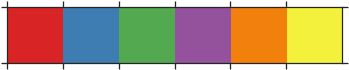

In [12]:
pal = sns.color_palette('Set1', n_colors=6, desat=0.9)#[::-1]
# pal = sns.color_palette('deep')
sns.palplot(pal)
sns.set_palette(pal)

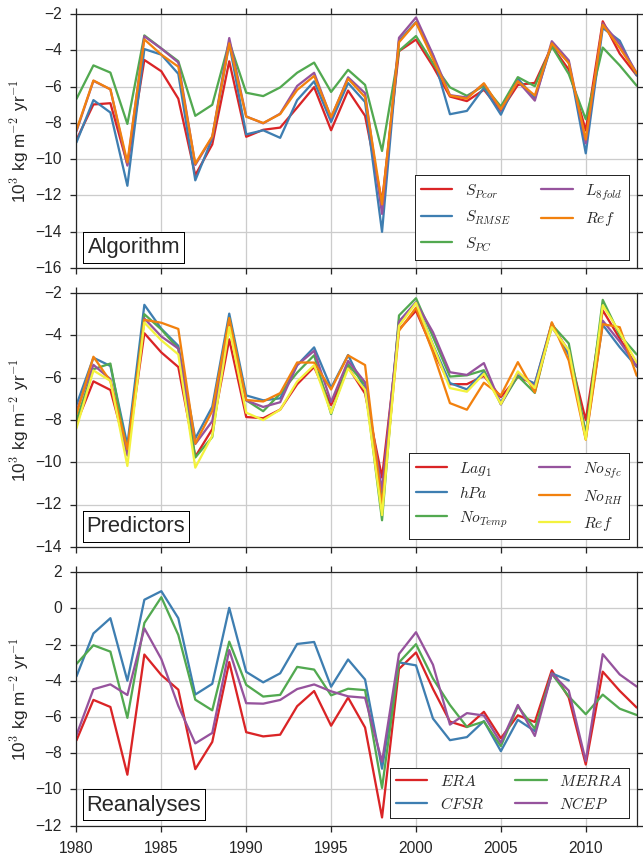

In [13]:
fig = plt.figure(figsize=(9, 12), dpi=200)
for i, ss in enumerate(sss):
    keys = keyss[ss]
    dft = dfd[ss][list(keys.keys())]
    dft.columns = [v[0] for v in keys.values()]
    ax = fig.add_subplot(3,1,i+1)
    dft.plot(ax=ax);
    
    ax.set_ylabel('10$^{3}$ kg m$^{-2}$ yr$^{-1}$')
    ax.set_xlabel('')
    if i < 2: 
        ax.set_xticklabels('')
    
    legend = ax.legend(loc='lower right', ncol=2)
    legend.set_frame_on(True)
    frame = legend.get_frame()
    frame.set_linewidth(1)
    
    plt.text(0.02, 0.06, titles[i], transform=ax.transAxes, fontsize=22,
     bbox=dict(facecolor='white', edgecolor='k', linewidth=1, pad=10.0))
    
plt.tight_layout()
plt.subplots_adjust(bottom=0.04)
plt.savefig(os.path.join(utils.get_plot_dir(), 'Fig_12.pdf'))